# **Implementing SVM from scratch**
In this tutorial, SVM will be coded from scratch, tested on linearly seprable data, and non-linearly seprable dataset (Text Classification)

Importing libraries

In [2]:
# importing some basic libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
style.use('ggplot')

# Text data download and preprocessing

In [3]:
df = pd.read_csv('/content/processed_data1.csv')
df.head()

,review,sentiment
0,one review ha mention watch 1 Oz episod youll ...,positive
1,wonder littl product film techniqu veri unassu...,positive
2,thought thi wa wonder way spend time hot summe...,positive
3,basic famili littl boy jake think zombi hi clo...,negative
4,petter mattei love time money visual stun film...,positive


In [4]:
sent = pd.Series(np.where(df.sentiment.values == 'positive',1,0))
sent
y_train = sent[0:399]
y_test = sent[400:499]
y_train.head()

0    1
1    1
2    1
3    0
4    1
dtype: int64

In [5]:
docs = df.review.to_numpy().tolist()
len(docs)

50000

In [6]:
bows=[]
for doc in docs[0:499]:
  bows.append(doc.split(" "))
sets=[]
for s in bows:
  sets.append(set(s))
wordSet=set().union(*sets)
len(wordSet)

10772

In [7]:
wordDicts=[]
for bow in bows:
  wordDict =dict.fromkeys(wordSet,0)
  for word in bow:
    wordDict[word]+=1
    wordDicts.append(wordDict)

In [8]:
def computeTF(wordDict,bow):
    tfDict = {}
    bowCount = len(bow)
    for word,count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

In [9]:
tfBows=[]
for i in range(len(bows)):
  tfBows.append(computeTF(wordDicts[i],bows[i]))

In [10]:
def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)

    idfDict = dict.fromkeys(docList[0].keys(),0)
    
    #Lets find the number of docs which contain word(Wi)
    for doc in docList:
        for word,val in doc.items():
            if val >0:
                idfDict[word]+=1
    #IDF calculation
    for word,val in idfDict.items():
        idfDict[word] = math.log10((N+1)/(float(val)+1.0))+1
    return idfDict

In [11]:
idfs = computeIDF([wordDict for wordDict in wordDicts])

In [12]:
def computeTFIDF(tfBow,idfs):
    tfidf ={}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [13]:
tfidfBows=[]
for i in range(len(bows)):
  tfidfBows.append(computeTFIDF(tfBows[i],idfs))

In [14]:
import pandas as pd
data_final_representaion=pd.DataFrame([tfidfBow for tfidfBow in tfidfBows])
data_final_representaion.head()

,ceasarean,1952,quaid,tenni,must,priscilla,congress,wander,difficult,basterd,...,hit,overdramat,cervi,italian,archaeologist,grier,boat,innuendo,snob,phoni
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.014898,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.028651,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.027736,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.038914,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020056,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#finalizing data
X_train = data_final_representaion[0:399]
X_test = data_final_representaion[400:499]
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np.where(y_train <= 0, -1, 1)
y_test = np.where(y_test <= 0, -1, 1)

# SVM Implementation

In [17]:
import numpy as np
from sklearn import metrics

class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    ##
      #fuction for training
    ##
    def fit(self, X, y,x_test=[],y_test=[]):
        n_samples, n_features = X.shape
        #insure data in correct form
        y_ = np.where(y <= 0, -1, 1)
        #how to initialize the wights (width=n_features as the input has):
        self.w = np.random.rand(n_features)
        #initialize bias
        self.b = 0

        #training loop:
        for iteration in range(self.n_iters):
            #Loop through X (input) i.e. SGD
            for idx, x_i in enumerate(X):
                #update rule:
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]
            
            # test accuarcy during traing:
            if(iteration %5==0):
              if len(x_test)>0: print(iteration,'_________________________________')
              c=0
              for i in range(len(x_test)):
                if clf.predict(x_test[i])==y_test[i]:
                    c+=1
              if len(x_test)>0: print(c/len(x_test))

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)


Testing on random linear data and visualization

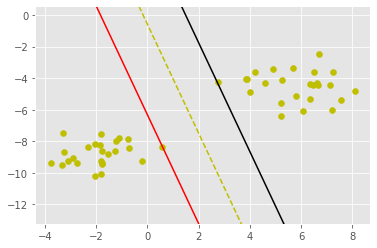

In [21]:

# Testing
if __name__ == "__main__":
    # Imports
    from sklearn import datasets
    import matplotlib.pyplot as plt

    X_linear, y_linear = datasets.make_blobs(
        n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40
    )
    # print(X)
    y_linear = np.where(y_linear == 0, -1, 1)

    clf = SVM()
    clf.fit(X_linear, y_linear)
    # predictions = clf.predict(X)

    # print(clf.w, clf.b)

    def visualize_svm():
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]
        X= X_linear
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker="o", c="y")

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])
        # print(x0_1,x0_2,'#############xx')
        x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
        x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)
        # print(x1_1,x1_2,'#############xx')

        x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
        x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

        x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
        x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "r")
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])

        plt.show()

    visualize_svm()

Testing on (Text data).

In [22]:
# Testing
if __name__ == "__main__":
    from sklearn import datasets
    import matplotlib.pyplot as plt
    clf = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=400)
    clf.fit(X_train, y_train,X_test,y_test)

0 _________________________________
0.46464646464646464
5 _________________________________
0.48484848484848486
10 _________________________________
0.46464646464646464
15 _________________________________
0.494949494949495
20 _________________________________
0.5050505050505051
25 _________________________________
0.5252525252525253
30 _________________________________
0.5252525252525253
35 _________________________________
0.5353535353535354
40 _________________________________
0.5353535353535354
45 _________________________________
0.5252525252525253
50 _________________________________
0.5252525252525253
55 _________________________________
0.5252525252525253
60 _________________________________
0.5252525252525253
65 _________________________________
0.5252525252525253
70 _________________________________
0.5353535353535354
75 _________________________________
0.5454545454545454
80 _________________________________
0.5454545454545454
85 _________________________________
0.545454545

**Result**: Text data is not linearly seperable, that is why accuracy was saturated at 0.5354 